In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from laspy.file import File

# Necessary to import pypwaves_updated.py from parent directory
import sys
sys.path.append('../')
import pypwaves_updated as pw
from point_density_functions import *

%matplotlib inline

## Comparing with LAS file
GPS timestamps kind of line up...the overall timeframe is identical to ~5 digits, but the offset is very different and the points don't line up exactly.  Also the point counts don't align, even accounting for pulses with multiple returns in the .las file.

In [2]:
# Adj GPS Time: Set both timestamps to zero for the first record
def adjust_time(df,time_field):
    # Function adds adj_gps_time to points or pulse dataframe, set to zero at the minimum timestamp.
    df['adj_gps_time'] = df[time_field] - df[time_field].min()
    return df

def label_returns(las_df):
    '''
    Parses the flag_byte into number of returns and return number, adds these fields to las_df.
    Input - las_df - dataframe from .laz or .lz file
    Output - first_return_df - only the first return points from las_df.
           - las_df - input dataframe with num_returns and return_num fields added 
    '''
    
    las_df['num_returns'] = np.floor(las_df['flag_byte']/16).astype(int)
    las_df['return_num'] = las_df['flag_byte']%16
    first_return_df = las_df[las_df['return_num']==1]
    first_return_df = first_return_df.reset_index(drop=True)
    return first_return_df, las_df


def pull_first_scan_gap(df):
    # Separate return num, only keep the first returns, add scan_gap, sort
    df['num_returns'] = np.floor(df['flag_byte']/16).astype(int)
    df['return_num'] = df['flag_byte']%16
    
    first_return_wall = df[df['return_num']==1]
    first_return_wall.sort_values(by=['gps_time'],inplace=True)
    first_return_wall.reset_index(inplace=True)
    first_return_wall.loc[1:,'scan_gap'] = [first_return_wall.loc[i+1,'scan_angle'] - first_return_wall.loc[i,'scan_angle'] for i in range(first_return_wall.shape[0]-1)]
    first_return_wall.loc[0,'scan_gap'] = 0
    first_return_wall['scan_angle_deg'] = first_return_wall['scan_angle']*.006
    return first_return_wall

In [3]:
# Load LAS points
las_df = pd.read_hdf("../../Data/parking_lot/las_points_180819.lz")

# Load pls anchor points
pls_anchor_df = pd.read_pickle("../../Data/fwf_data/anchors_180819.pkl")


# Separate out the first returns only
las_df = adjust_time(las_df,'gps_time')
pls_anchor_df = adjust_time(pls_anchor_df,'gps_time')

# Sort records by timestamp
las_df.sort_values(by=['adj_gps_time'],inplace=True)
pls_anchor_df.sort_values(by=['adj_gps_time'],inplace=True)

# Reset indices
las_df.reset_index(drop=True,inplace=True)
pls_anchor_df.reset_index(drop=True,inplace=True)

# Load the pulsewaves file
pls_file = "../../Data/fwf_data/180819_pls/10552_NYU_M2_Pulse_Waves_MTA_Resolved-Scanner1-190511_180819_1-originalpoints.pls"
pulsewave = pw.openPLS(pls_file)

In [6]:
# First returns only
first_return_df = pull_first_scan_gap(las_df)
# print("Number of points in .las file: {:,d}".format(las_df.shape[0]))
# print("Number of first return points: {:,d}".format(first_return_df.shape[0]))
# print("Number of pulses in .pls file: {:,d}".format(pls_anchor_df.shape[0]))

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

### Comparing Timestamps
The timespan for the two files agree almost exactly.  
LAS file uses seconds since midnight Saturday night.  
PLS file uses GPS Week Time (seconds since midnight on previous Sunday night).  
Oddly, the files are still phased by 18 seconds, even after accounting for the 6-day offset.

In [7]:
# Compare time ranges
las_range = (first_return_df['gps_time'].min(),first_return_df['gps_time'].max())
anchor_range = (pls_anchor_df['gps_time'].min(),pls_anchor_df['gps_time'].max())

print("LAS range: {:2.3f} seconds".format(las_range[1]-las_range[0]))
print("PLS range: {:2.3f} seconds".format(anchor_range[1]-anchor_range[0]))

LAS range: 54.803 seconds
PLS range: 54.803 seconds


In [8]:
diff = anchor_range[0] - las_range[0] -(6*24*60*60-18)
# pls_anchor_df['adj_gps_time'] += diff
anchor_range[0] - las_range[0]

518382.00001299294

In [9]:
pls_anchor_df['adj_gps_time'] = pls_anchor_df['adj_gps_time']+ diff

In [ ]:
# First bit of Global Encoding indicates the gps time model: 0 for GPS Week Time, 
# 1 for GPS Adj Standard Time (Standard Time - 1e9)
# The origin of standard GPS Time is defined as midnight of the morning of January 6, 1980.
# print(inFile.header.global_encoding%2)

In [ ]:
# Checking the GPS encoding for LAS file - Type 0 indicates GPS Week Time, otherwise GPS Adjusted Time.
# This seems to mean GPS Week Time
#print("LAS time type: ",las_header.header.get_gps_time_type())

print("\nLAS:")
print("GPS Time at start of run: {:2.3f} days".format(las_range[0]/ (60*60*24)))
# So the run was probably on a Sunday?
print("\nPLS:")
print("GPS Time at start of run: {:2.3f} days".format(anchor_range[0]/(60*60*24)))

In [ ]:
# Oddly, the files are still phased by 18 seconds
print("Difference in timestamps, accounting for GPS convention: {:2.2f} seconds".format(
                        anchor_range[0] - las_range[0] - (6*24*60*60)))

## Extract points with no corresponding pulse
Points that don't have a pulse within $\pm \epsilon$ seconds.

In [10]:
# For each point, find the pulse at the closest 
# previous (or equal) timestamp
pls_indices = np.searchsorted(pls_anchor_df['adj_gps_time'],
                             first_return_df['adj_gps_time'],side='right')-1

In [11]:
pls_indices_forward = np.array([min(p+1,pls_anchor_df.shape[0]-1) for p in pls_indices])

In [12]:
# Only the nearest point can associate with a given pulse.
pls_indices[0] = 0
for i,pls in enumerate(pls_indices[1:]):
    if pls_indices[i] == pls_indices[i-1]:
#     if np.isin(pls,pls_indices[:i-1]):
        pls_indices[i] = 0

In [13]:
# Calculate time difference between each point and closest pulse
epsilon = .000003 # This is too loose, but it works for just looking at points that clearly have no pulse.
time_diff = np.array(first_return_df['adj_gps_time']) - \
            np.array(pls_anchor_df['adj_gps_time'].iloc[pls_indices])

time_diff_prev = np.array(first_return_df['adj_gps_time']) - \
            np.array(pls_anchor_df['adj_gps_time'].iloc[pls_indices_forward])

# If time difference > epsilon, set pls_index to zero
for i,t in enumerate(time_diff):
    if t > epsilon:
        if abs(time_diff_prev[i]) < epsilon:
#             print("time_diff: {:2.4f}".format(time_diff[i]))
#             print("time_diff_prev: {:2.4f}".format(time_diff_prev[i]))
            pls_indices[i] = pls_indices_forward[i]
#             print("It happened")
        else:
            pls_indices[i] = 0

# (Repeat since we may have added some repeats) Only the nearest point can associate with a given pulse.
pls_indices[0] = 0
for i,pls in enumerate(pls_indices[1:]):
    if pls_indices[i] == pls_indices[i-1]:
#     if np.isin(pls,pls_indices[:i-1]):
        pls_indices[i] = 0

In [14]:
first_return_df['pulse_index'] = pls_indices

# Points without pulses
no_pulse = first_return_df[first_return_df['pulse_index']==0]
with_pulse = first_return_df[first_return_df['pulse_index']>0]

# Find pulses with no point
pulse_with_point = pls_anchor_df.iloc[with_pulse['pulse_index']]
pulse_without_point = pls_anchor_df.drop(with_pulse['pulse_index'])

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# 0.3825
print("Fraction of points without a corresponding pulse: {:2.4f}".format(sum(pls_indices==0)/pls_indices.shape[0]))

### Are pulses near enough that two peaks could show up from neighbor pulses?
No, there are ~60 samples per pulse, and each sample is 1 nanosecond apart. Pulses are 2500 nanoseconds apart.

In [ ]:
print("Seconds between pulses: {}".format((pls_anchor_df.iloc[5767874]['adj_gps_time']-pls_anchor_df.iloc[5767872]['adj_gps_time'])/2))

pls = pulsewave.get_pulse(5767871)
print("Nanoseconds per sample: {}".format(pulsewave.vlrs[pls.pulse_descriptor].record.sample_units))

## Missing Point waveforms
The streaks of missing points, do the waveforms of nearby points look different? Are points being lost in a wider waveform?

In [ ]:
pulsewave.get_waves(0)

In [ ]:
pulsewave.get_waves(1059)

In [ ]:
# Skip over the water
streaks_df = with_pulse[with_pulse['gps_time']>60204]

# Identify a point with scan deg i n[24,28]
miss_pts_index = (streaks_df['scan_angle_deg']>24) & \
                      (streaks_df['scan_angle_deg']<28) & \
                      (streaks_df['scan_gap'].isin([-9,-10,-11]))

# Annoyingly, this create a list of booleans indicating the previous point, used with df.loc[]
miss_pts_rows = list(miss_pts_index.reset_index(drop=True))
add_end = miss_pts_rows.pop(0)
miss_pts_rows.append(add_end)

# DFs for preceding and following points of missing points
follow_pt = streaks_df[miss_pts_index]
prev_pt = streaks_df.loc[list(miss_pts_rows)]

In [ ]:
def plot_missing_pts(df_first,col,ylabel='Point Count'):
    # Prints the histogram of col for each of: all points, after single miss pts, and after multiple miss pts
    # Avg Scan angle for missing pts vs regular
    after_single_miss = df_first[df_first['scan_gap'].isin([-10,-11])]
    after_multiple_miss = df_first[df_first['scan_gap'].isin([-21,-20,-15,-16])]
    
    
    plt.figure(figsize=[20,5])

    plt.subplot(1,3,1)
    ax = df_first[col].hist(bins=100)
    ax.set_xlabel(col)
    ax.set_ylabel(ylabel)
    ax.set_title("All points")

    plt.subplot(1,3,2)
    ax = after_single_miss[col].hist(bins=100)
    ax.set_xlabel(col)
    ax.set_title("Single Missing Point")

    plt.subplot(1,3,3)
    ax = after_multiple_miss[col].hist(bins=100)
    ax.set_xlabel(col)
    ax.set_title("Multiple Missing Points")    
    
# Look into wave segments
def plot_all_returns(pulse_number):
    # Pulls the waveform and plots the outgoing pulse and 1 or multiple returns, depending on what's available.
    a = pulsewave.get_waves(pulse_number).segments
    plt.figure(figsize=[20,8])
    for r in range(len(a)):
        plt.subplot(1,len(a),r+1)

        if r == 0:
            plt.plot(a[r][3],range(len(a[r][3])),'r')
            plt.title("Outgoing",fontsize=13)
            plt.ylabel("Sample Number",fontsize=13)
            plt.xlabel("Amplitude",fontsize=13)
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)
        else:
            plt.plot(a[r][3],range(len(a[r][3])),'b')
            plt.title("Segment {}".format(r),fontsize=13)
            plt.xlabel("Amplitude",fontsize=13)
            plt.xticks(fontsize=13)
            plt.yticks(fontsize=13)

    plt.show()

In [ ]:
for i in range(4714066,4714066+5):
    print("Pulse {}".format(i))
    plot_all_returns(i)

In [ ]:
for p in range(4714066,4714066+5):
    pls = pulsewave.get_pulse(4754061)
    print(len(pulsewave.vlrs[pls.pulse_descriptor].sampling_records))

In [ ]:
# Do any pulses have more than 2 returns?
more = []
for i in range(4000000,4714061):
    if len(pulsewave.get_waves(int(i)).segments) > 3:
        print("Yes: ",i)
        more.append(i)

### Missing point streaks
A single scan line through 3 missing point streaks, in both the pulse file and point file.

In [15]:
scan_pts = first_return_df[(first_return_df['gps_time']>65355.483922)&(first_return_df['gps_time']<65355.484383)]
scan_pls = pls_anchor_df[(pls_anchor_df['adj_gps_time']>35.952737)&(pls_anchor_df['adj_gps_time']<35.953197)]
scan_pts

,index,X,Y,Z,intensity,flag_byte,classification_flags,classification_byte,user_data,scan_angle,...,gps_time,x_scaled,y_scaled,z_scaled,adj_gps_time,num_returns,return_num,scan_gap,scan_angle_deg,pulse_index
6454906,6783070,-433071,215487,13945,1711,17,0,0,0,-3893,...,65355.483923,976566.929,173215.487,13.945,35.952738,1,1,-5.0,-23.358,5767866
6454907,6783071,-432607,215064,14075,1462,17,0,0,0,-3898,...,65355.483926,976567.393,173215.064,14.075,35.952741,1,1,-5.0,-23.388,5767867
6454908,6783072,-432038,214559,14047,1497,17,0,0,0,-3904,...,65355.483929,976567.962,173214.559,14.047,35.952744,1,1,-6.0,-23.424,0
6454909,6783073,-431506,214094,13929,1529,17,0,0,0,-3909,...,65355.483931,976568.494,173214.094,13.929,35.952746,1,1,-5.0,-23.454,5767869
6454910,6783074,-430917,213579,13807,1961,17,0,0,0,-3914,...,65355.483934,976569.083,173213.579,13.807,35.952749,1,1,-5.0,-23.484,5767870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455062,6783226,-340243,132851,15321,1664,17,0,0,0,-4791,...,65355.484371,976659.757,173132.851,15.321,35.953186,1,1,-11.0,-28.746,5768016
6455063,6783227,-339674,132346,15324,1683,17,0,0,0,-4796,...,65355.484373,976660.326,173132.346,15.324,35.953188,1,1,-5.0,-28.776,0
6455064,6783228,-339178,131901,15364,1706,17,0,0,0,-4801,...,65355.484376,976660.822,173131.901,15.364,35.953191,1,1,-5.0,-28.806,5768017
6455065,6783229,-338528,131328,15281,1727,17,0,0,0,-4806,...,65355.484378,976661.472,173131.328,15.281,35.953193,1,1,-5.0,-28.836,5768018


In [ ]:
# Left side of scan
scan_pts = first_return_df[(first_return_df['adj_gps_time']>36.78871)&(first_return_df['adj_gps_time']<36.789215)]
scan_pls = pls_anchor_df[(pls_anchor_df['adj_gps_time']>36.78871)&(pls_anchor_df['adj_gps_time']<36.789215)]

In [ ]:
# diff = 2.5e-6 * 5
first_return_df[(first_return_df['gps_time']>65356.319892)&(first_return_df['gps_time']<65356.319899)]

In [ ]:
# scan_pts[scan_pts['adj_gps_time']>36.788726].iloc[:15]
scan_pls.iloc[:15]

([<matplotlib.axis.YTick at 0x7f8162785940>,
 <a list of 20 Text yticklabel objects>)

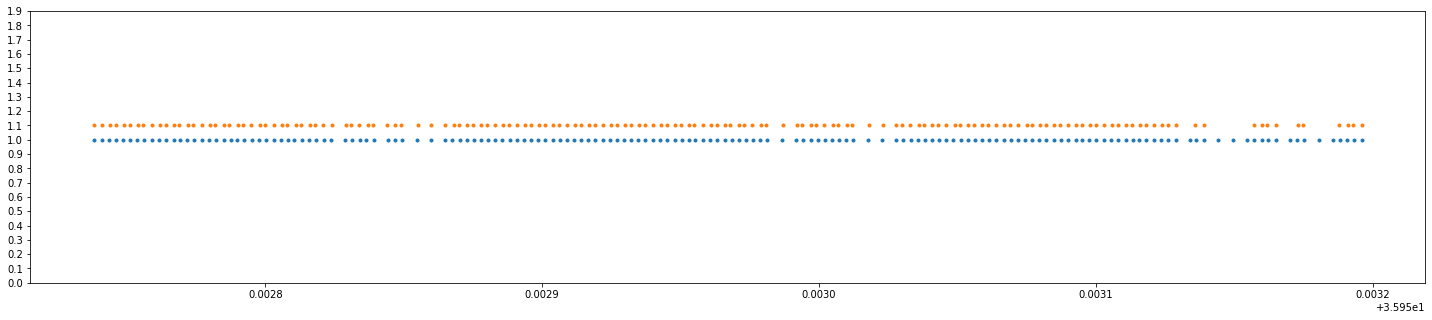

In [17]:
plt.figure(figsize=[25,5])
plt.plot(scan_pts['adj_gps_time'],np.ones(scan_pts.shape[0]),'.')
plt.plot(scan_pls['adj_gps_time'],1.1*np.ones(scan_pls.shape[0]),'.')
plt.yticks(np.arange(0,2,0.1))

In [16]:
j=0
print("All pulses for one scan line through a missing point streak")
print("*"*60,"\n")
for i in np.arange(5767871+25,5767871+45):
    try:
        num_cloud_returns = int(first_return_df[first_return_df['pulse_index']==i]['num_returns'])
    except TypeError:
        num_cloud_returns = "Timestamps did not line up"
    print("Pulse {} \nAdjusted time: {:2.6f}".format(i,pls_anchor_df.loc[i]['adj_gps_time']))
    print("Number of point cloud returns: {}".format(num_cloud_returns))
    print("Number of Pulsewave returns: {}".format(len(pulsewave.get_waves(int(i)).segments)-1))
    plot_all_returns(int(i))
#     if len(pulsewave.get_waves(int(i)).segments)>2:
#         print(j)
#         j+=1
    

All pulses for one scan line through a missing point streak
************************************************************ 

Pulse 5767896 
Adjusted time: 35.952816
Number of point cloud returns: 1


NameError: name 'pulsewave' is not defined

### Do the point cloud points fall along the dx/dy/dz line?

In [35]:
# point = scan_pts.loc[6454906]
# pulse = pulsewave.get_pulse(5767866)
# wv = pulsewave.get_waves(5767866)
point = scan_pts.loc[6455064]
pulse = pulsewave.get_pulse(5768017)
wv = pulsewave.get_waves(5768017)


Key 0 Duration Anchor: 4294961302
Key 1 Duration Anchor: 1289662
Key 2 Duration Anchor: 1290425


In [36]:
(point['x_scaled'] - pulse.x_anchor)/pulse.dx

-5039.355839771192

In [37]:
(point['y_scaled'] - pulse.y_anchor)/pulse.dy

23367.83470392844

In [38]:
(point['z_scaled'] - pulse.z_anchor)/pulse.dz

3012.0405114940436

### Do all the multi-returns fall along the dx/dy/dz line?
Yes, it looks like they do.  Example is below.

In [24]:
'''Do all the multi-returns fall along the dx/dy/dz line?
Pulse 4714061
Point index (first return) 5304263
Num returns: 5
'''
# Collect all 5 points associated with that pulse
mr = las_df[(las_df['gps_time']>65350.854972)&(las_df['gps_time']<65350.854975)]

# Calculate the time diffs
x_diff = np.array(mr['x_scaled'][:4]) - np.array(mr['x_scaled'][1:])
y_diff = np.array(mr['y_scaled'][:4]) - np.array(mr['y_scaled'][1:])
z_diff = np.array(mr['z_scaled'][:4]) - np.array(mr['z_scaled'][1:])

# X,Y, and Z are proportional, 
print("z/y: ",np.divide(z_diff,y_diff))
print("x/y: ",np.divide(x_diff,y_diff))
print("z/x: ",np.divide(z_diff,x_diff))

# Not sure why there are only 2 segments in the fwf, maybe I'm misaligning the fwf?
w = pulsewave.get_waves(4714061)
len(w.segments)

z/y:  [4.65901981 4.66066998 4.6612803  4.66001426]
x/y:  [-1.43482795 -1.43362283 -1.43629584 -1.43406985]
z/x:  [-3.24709302 -3.2509736  -3.24534833 -3.24950298]
Key 0 Duration Anchor: 4294960103
Key 1 Duration Anchor: 4294829151
Key 2 Duration Anchor: 4294829914


3

In [ ]:
w = pulsewave.get_waves(4714061)
len(w.segments)

In [ ]:
# 4128165 high on wall
# 4124759 low on wall

plt.figure(figsize=[7,12])
heights = [(a-9)/3.28084 for a in [99.721,53.669,13.376]]
for i,p in enumerate([2915445,2915424,2915403]):
    a = pulsewave.get_waves(int(p)).segments
    print("Max amplitude: {:2.4f}".format(max(a[1][3])))
    plt.subplot(3,1,i+1)
    plt.plot(a[1][3],range(len(a[1][3])),'b',label='Wall Height = {:2.1f}m'.format(heights[i]))
    plt.xlim([0,220])
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(loc='upper right',fontsize=18)
    if i == 2:
        plt.xlabel("Amplitude",fontsize=18)


In [ ]:
# Print the waves from the windows on the Army Terminal Bldg

for i in np.arange(0,20):
    p = int(follow_pt.iloc[i]['pulse_index'])
    print("Pulse {} adjusted time: {:2.8f}".format(p, \
                                                   pls_anchor_df.loc[i]['adj_gps_time']+60205.194250-25.532044))
    print("Number of point cloud returns: {}".format(int(follow_pt.iloc[i]['num_returns'])))
    print("Number of Pulsewave returns: {}".format(len(pulsewave.get_waves(p).segments)-1))
    plot_all_returns(p)

In [ ]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

plt.figure(figsize=[20,10])
# for i in np.arange(3775808,3775808+30):
for i in np.arange(5761020-200,5761020-100):
    s = pulsewave.get_waves(int(i)).segments
    for r in range(1,len(s)):
        ax1 = plt.subplot(1,3,1)
        ax1.plot(s[r][0],label=[i,r])
        ax1.set_title("X")
        ax2 = plt.subplot(1,3,2)
        ax2.plot(s[r][1],label=[i,r])
        ax2.set_title("Y")
        ax3 = plt.subplot(1,3,3)
        ax3.plot(s[r][2],label=[i,r])
        ax3.set_title("Z")

# plt.legend(loc='best')
plt.show()

In [ ]:

plt.plot(b[1][0],'bo',label=822)
plt.plot(b[2][0],'ro',label=822_2)
plt.plot(c[1][0],'yx',label=823)
plt.plot(a[1][0],'gx',label=821)
plt.legend()

In [ ]:
pls_anchor_df.loc[335]

In [ ]:
pulsewave.t_scale

## Time between returns
Looking at the typical timing between first, second, nth returns for the same pulse.  
Result: All associated returns have the exact same timestamp!  

In [ ]:
returns_from_same_pulse = las_df.iloc[336020:336028]
print("Timestamp range of 8 returns for same pulse: {:2.5f} seconds".format(returns_from_same_pulse['gps_time'].max()-returns_from_same_pulse['gps_time'].min()))
las_df.iloc[336020:336028][['num_returns','return_num','gps_time']] 

In [ ]:
# Q: Are multi-return points less likely to line up with a pulse?
# A: No.
print("Mean number of returns for points \nwith/without a corresponding pulse\n"+"*"*40)
print("Points with no pulse: {:2.4f} returns".format(no_pulse['num_returns'].mean()))
print("Points with pulse: {:2.4f} returns".format(with_pulse['num_returns'].mean()))
print("Overall: {:2.4f} returns".format(first_return_df['num_returns'].mean()))

In [ ]:
# Q: Are pulses without a point more likely to be noisy (anchor above or below expected helicopter altitude)?  
# A: No they are not
print("All pulses, % that are noisy:: {:2.4%}".format((sum(pls_anchor_df['z']>1100) + sum(pls_anchor_df['z']< 600))/pls_anchor_df.shape[0]))
print("Pulses with points: {:2.4%}".format((sum(pulse_with_point['z']>1100) + sum(pulse_with_point['z']< 600))/pulse_with_point.shape[0]))
print("Pulses without points: {:2.4%}".format((sum(pulse_without_point['z']>1100) + sum(pulse_without_point['z']< 600))/pulse_without_point.shape[0]))   


## Temporal Distribution Plotting
Tooling, then comparing temporal distribution of points with and without a corresponding pulse.

In [ ]:
def create_bins(df,ms_per_bin,time_field='adj_gps_time'):
    '''Function returns a numpy array of bin edges, 
    where the number of bins = (max_time - min_time)*1e/ms_per_bin 
    where time is in seconds.'''
    min_val = int(np.floor(df[time_field]*1e3).min())
    max_val = int(np.ceil(df[time_field]*1e3).max())
    bin_range = range(min_val,max_val,ms_per_bin)
    bin_arr = np.array(bin_range)/1e3
    return bin_arr

def plot_range(df,first_point,last_point,ms_per_bin):
    '''
    Plots the temporal density and the specific points within the [first_point,last_point] range.
    Vertical lines are the bin edges
    Red dots are the points within the bin edges
    Blue is the distribution of the points
    '''
    bin_plot = create_bins(df[first_point:last_point],ms_per_bin)
    hist_plot,_ = np.histogram(df['adj_gps_time'][first_point:last_point],bin_plot)
    plt.figure(figsize=[18,12])
    plt.plot(df['adj_gps_time'][first_point:last_point], \
             hist_plot.mean()*np.ones(last_point-first_point), "x",markersize=8,label="Points")
    plt.plot(bin_plot[:-1]+(ms_per_bin/2000),hist_plot,"ro",markersize=12,label="Points in bin")
    plt.vlines(bin_plot,hist_plot.min(),hist_plot.max(),linestyle=":",color='coral',label="Bin edges")
    
    plt.xlabel("Time in Seconds",fontsize=15)
    plt.ylabel("Points per {}ms bin".format(ms_per_bin),fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend()

def points_per_scan(scan_angle):
    '''takes scan_angle as Series, counts the number of "jumps" in the scan angle, indicating start of a new scan
    then divides the number of points in scan_angle to return points / scan'''
    delta_angle = [scan_angle.iloc[i+1]-scan_angle.iloc[i] for i in range(len(scan_angle)-1)]
    print("Done")
    scan_count = sum(abs(np.array(delta_angle)) > scan_angle.max())
    print("Number of scans: {}".format(scan_count))
    print("Points per scan: {:2.2f}".format(len(scan_angle)/scan_count))    
    return len(scan_angle)/scan_count, scan_count

def scan_temporal_profile(df):
    '''
    Identifies each scan by the reset in scan_angle, calculates mean and SD for each of: 
    - time of each scan
    - time of each gap
    - points in each scan 
    Input: Full points dataframe
    '''
    df.reset_index(inplace=True)
    delta_angle=[0]
    delta_angle.extend([df['scan_angle'].iloc[i+1]-df['scan_angle'].iloc[i] for i in range(df.shape[0]-1)])
    df['delta_angle'] = delta_angle
    first_pts = df[abs(df['delta_angle'])>df['scan_angle'].max()]
    fpi = first_pts.index
    
    gap_times = np.array(df.iloc[fpi]['adj_gps_time']) - np.array(df.iloc[fpi-1]['adj_gps_time'])
    total_cycle_times = np.array(df.iloc[fpi[1:]]['adj_gps_time']) - np.array(df.iloc[fpi[:-1]]['adj_gps_time'])
    scan_times = total_cycle_times - gap_times[:-1]
    print("Gap Time Mean (ms): ",gap_times.mean()*1000)
    print("Gap Time StdDev (ms): ",gap_times.std()*1000)    
    print("Scan Time Mean (ms): ",scan_times.mean()*1000)
    print("Scan Time StdDev (ms): ",scan_times.std()*1000)    

    # Pts per scan distribution
    pts_per_scan = np.array([fpi[i] - fpi[i-1] for i in range(1,len(fpi))])
    print("Points per Scan Mean: ",pts_per_scan.mean())
    print("Points per Scan StdDev: ",pts_per_scan.std())    

In [ ]:
# Profiling the cycles while over land
scan_temporal_profile(first_return_df[:500000])

In [ ]:
# Plots the window/cycle phasing problem
first_point = 681048
last_point =  first_point+13000

plot_range(first_return_df,first_point,last_point,ms_per_bin=10)

In [ ]:
# Create the bin edges
bin_arr = create_bins(first_return_df,ms_per_bin=45)

# Use np.histogram to find the number of points per bin
hist,_ = np.histogram(first_return_df['adj_gps_time'],bin_arr)
hist_no_pulse,_ = np.histogram(no_pulse['adj_gps_time'],bin_arr)
hist_with_pulse,_ = np.histogram(with_pulse['adj_gps_time'],bin_arr)
# Same for Pulses
hist_pulse,_ = np.histogram(pls_anchor_df['adj_gps_time'],bin_arr)
hist_pls_with_pt,_ = np.histogram(pulse_with_point['adj_gps_time'],bin_arr)
hist_pls_no_pt,_ = np.histogram(pulse_without_point['adj_gps_time'],bin_arr)

In [ ]:
# This plots the time distribution of points
one_scan = first_return_df[(first_return_df['adj_gps_time'] > 2.66)&(first_return_df['adj_gps_time'] < 2.671)]
plt.figure(figsize=[15,2])
plt.plot(one_scan['adj_gps_time'],np.ones(len(one_scan)),'x')
plt.title("Scan pattern - Points over time")
plt.xlabel("Time in Seconds")
plt.tick_params(
    axis='y',          
    which='both',    
    left=False,      
    labelleft=False)

In [ ]:
# Plot all points, points w/ pulse, and points w/o pulse in subplots
plt.figure(figsize=(20,30))
plt.subplot(3, 1, 1)
plt.plot(bin_arr[:-1],hist,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("All points",fontsize=15)

plt.subplot(3, 1, 2)
plt.plot(bin_arr[:-1],hist_with_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points with a pulse",fontsize=15)

plt.subplot(3, 1, 3)
plt.plot(bin_arr[:-1],hist_no_pulse,'+')
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 10 miliseconds",fontsize=15)
plt.title("Points without a pulse",fontsize=15)

In [ ]:
# Plot all points, and decomposed into with/without a corresponding pulse.  Also includes points with no pulse.

plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.plot(bin_arr[:-1],hist_with_pulse,'y+',label="With pulse")
plt.plot(bin_arr[:-1],hist_no_pulse,'r+',label="No pulse")
plt.plot(bin_arr[:-1],hist_pls_no_pt,'b+',label="Pulse w/o point")

plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.legend(fontsize=15)
plt.title("Temporal distribution of points/pulses from one flight",fontsize=18)

In [ ]:
# Plot all pulses, and decomposed into with/without a corresponding point
plt.figure(figsize=(20,17))


plt.plot(bin_arr[:-1],hist_pulse,'g+',label="All pulses")
plt.plot(bin_arr[:-1],hist_pls_with_pt,'k+',label="With point")
plt.plot(bin_arr[:-1],hist_pls_no_pt,'b+',label="Without point")

plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 50 miliseconds",fontsize=15)
plt.legend(fontsize=15)
plt.title("Temporal distribution of pulses from one flight",fontsize=18)

In [ ]:
# Plot all the points, full flight path
plt.figure(figsize=(20,17))

plt.plot(bin_arr[:-1],hist,'g+',label="All points")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Seconds",fontsize=15)
plt.ylabel("Points per 45 miliseconds",fontsize=15)
plt.title("Temporal distribution of points from one flight",fontsize=18)